## check things

In [1]:
!nvidia-smi

Wed Jun  5 17:22:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
conda env list

# conda environments:
#
myenv                    /home/ai4054/.conda/envs/myenv
pim-env               *  /home/ai4054/.conda/envs/pim-env
base                     /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0
netcdf-py39              /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/netcdf-py39
pytorch-2.2.2            /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/pytorch-2.2.2
tensorflow-2.12.1        /lustrefs/disk/modules/easybuild/software/Mamba/23.11.0-0/envs/tensorflow-2.12.1


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda list

# packages in environment at /home/ai4054/.conda/envs/pim-env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alembic                   1.13.1                   pypi_0    pypi
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hd1e30aa_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge

In [6]:
import sys
print(sys.executable)

/home/ai4054/.conda/envs/pim-env/bin/python


In [7]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

pim-env


In [9]:
import xgboost
import catboost
import imblearn
import lightgbm

# Load data

In [2]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Download dataset
!kaggle competitions download -c forest-type-classification-spai

100% 463k/463k [00:00<00:00, 611kB/s]
100% 463k/463k [00:00<00:00, 611kB/s]


In [4]:
!unzip /content/forest-type-classification-spai.zip && rm -rf /content/forest-type-classification-spai.zip

Archive:  /content/forest-type-classification-spai.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import and Visualize data

In [61]:
import os
def create_folders_if_not_exist(*paths):
    for path in paths:
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

# PATH to dataset and to Save the results
data_path = 'dataset'
results_path = 'results/multmodels_optuna/features01-suggest'
create_folders_if_not_exist(data_path, results_path)

Ensured directory exists: dataset
Ensured directory exists: results/multmodels_optuna/features01-suggest


In [48]:
# data_path = '/content/'
# results_path = '/content/' + results_path

In [62]:
import pandas as pd

# Load the training CSV file to check its contents and structure
train_file_path = f'{data_path}/train.csv'
train_df = pd.read_csv(train_file_path)
test_file_path = f'{data_path}/test.csv'
test_df = pd.read_csv(test_file_path)

# Display the first few rows of the training dataframe
train_df.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,293,1927,1038,278,475,453,987,1773,2184,1900,2343,3039,MDF
1,3212,197,1598,697,201,347,228,682,1982,2449,2254,2685,2690,DDF
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,2392,2671,2683,MDF
3,17020,132,1560,689,189,408,175,609,2117,2907,3024,3005,2955,MDF
4,5967,241,1944,1131,362,538,487,918,1549,1844,1702,2077,2043,MDF


## Data Preprocess

In [63]:
# Encode labels to numbers
from sklearn.preprocessing import LabelEncoder

# Fit the label encoder on the original labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df['nforest_type'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original to Encoded):", label_mapping)
y_encoded

Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}


array([2, 0, 2, ..., 0, 2, 2])

In [64]:
from sklearn.decomposition import PCA

def add_features(row) :

    # features01(Jane's code): Rax + NDVI, EVI, ...,pca3 (29 features)
    pca = PCA(n_components=3)
    df_pca = pca.fit_transform(row[['b8_a', 'b6', 'b12', 'b5', 'b11', 'b3', 'b4', 'b1', 'b8', 'b7', 'b2', 'b9']])

    row['NDVI'] = (row['b8'] - row['b4']) / (row['b8'] + row['b4'])
    row['EVI'] = 2.5 * ((row['b8'] - row['b4']) / (row['b8'] + 6 * row['b4'] - 7.5 * row['b2'] + 1.01))
    row['NDWI '] = (row['b3'] - row['b8']) / (row['b3'] + row['b8'])
    row['SAVI '] = (row['b8'] - row['b4']) * (1 + 0.5) / (row['b8'] + row['b4'] + 0.5)
    row['MSAVI'] = (2 * row['b8'] + 1 - ( (2 * row['b8'] + 1) ** 2 - 8 * (row['b8'] - row['b4'])) ** (1 / 2)) / 2
    row['GNDVI '] = (row['b8'] - row['b3']) / (row['b8'] + row['b3'])
    row['RENDVI '] = (row['b8'] - row['b5']) / (row['b8'] + row['b5'])
    row['NDMI '] = (row['b8'] - row['b11']) / (row['b8'] + row['b11'])
    row['GRVI'] = (row['b3'] - row['b4']) / (row['b3'] + row['b4'])
    row['TVI'] = ( (row['b8'] - row['b4']) / (row['b8'] + row['b4'] + 0.5) ) ** (1 / 2)
    row['MCARI'] = ((row['b5'] - row['b4']) - 0.2 * (row['b5'] - row['b3'])) / (row['b5'] / row['b4'])
    row['BSI'] =  ((row['b11'] + row['b4']) - (row['b8'] + row['b2'])) / ((row['b11'] + row['b4']) + (row['b8'] + row['b2']))
    row['NBR'] = (row['b8'] - row['b12']) / (row['b8'] + row['b12'])
    row['MSI'] = row['b11'] / row['b8']

    row['pca1'] = df_pca[:, 0]
    row['pca2'] = df_pca[:, 1]
    row['pca3'] = df_pca[:, 2]


    return row

train_df_new = add_features(train_df)
test_df_new = add_features(test_df)
train_df_new.head()

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,...,NDMI,GRVI,TVI,MCARI,BSI,NBR,MSI,pca1,pca2,pca3
0,2002,293,1927,1038,278,475,453,987,1773,2184,...,-0.007055,0.023707,0.784110,198.089970,0.044318,0.293397,1.014211,-690.036125,163.599803,216.061962
1,3212,197,1598,697,201,347,228,682,1982,2449,...,0.170301,0.206957,0.903390,129.378299,-0.146928,0.527618,0.708962,-446.551249,-422.101998,-24.866739
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,...,0.095489,0.087420,0.687629,227.331148,-0.087510,0.397604,0.825669,-9.753655,1076.920288,-302.257004
3,17020,132,1560,689,189,408,175,609,2117,2907,...,0.319372,0.399657,0.943637,113.160920,-0.298707,0.628872,0.515873,406.098925,-730.876614,-90.372846
4,5967,241,1944,1131,362,538,487,918,1549,1844,...,-0.066374,0.049756,0.744930,188.327887,0.081646,0.201553,1.142186,-1503.491734,478.454826,421.529957


In [65]:
train_df_new['nforest_type']

0        MDF
1        DDF
2        MDF
3        MDF
4        MDF
        ... 
13048    DDF
13049    DDF
13050    DDF
13051    MDF
13052    MDF
Name: nforest_type, Length: 13053, dtype: object

In [66]:
train_df_new.to_csv(f'{results_path}/pim_prepdata_feat01_train.csv', index=False)
test_df_new.to_csv(f'{results_path}/pim_prepdata__feat01_test.csv', index=False)

In [67]:
#Identify Non-Numeric Columns (should be the labels one ('nforest_type'), we change labels-->numbers)

# Find columns with non-numeric values in train data
non_numeric_columns_train = train_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in train data:", non_numeric_columns_train)

# Find columns with non-numeric values in test data
non_numeric_columns_test = test_df_new.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in test data:", non_numeric_columns_test)

Non-numeric columns in train data: Index(['nforest_type'], dtype='object')
Non-numeric columns in test data: Index([], dtype='object')


In [68]:
#Handle Non-Numeric Values
from sklearn.preprocessing import LabelEncoder
train_df_new_num = train_df_new.copy()
test_df_new_num = test_df_new.copy()

# Encode non-numeric values in train data
label_encoders = {}
for col in non_numeric_columns_train:
    le = LabelEncoder()
    train_df_new_num[col] = le.fit_transform(train_df_new_num[col].astype(str))
    label_encoders[col] = le

# Encode non-numeric values in test data using the same encoders
for col in non_numeric_columns_test:
    le = label_encoders.get(col, LabelEncoder())
    test_df_new_num[col] = le.transform(test_df_new_num[col].astype(str)) if col in label_encoders else le.fit_transform(test_df_new_num[col].astype(str))

# Verify the encoding
print(train_df_new_num.head())
print(test_df_new_num.head())

      id   b1   b11   b12   b2    b3   b4    b5    b6    b7  ...     NDMI   \
0   2002  293  1927  1038  278   475  453   987  1773  2184  ... -0.007055   
1   3212  197  1598   697  201   347  228   682  1982  2449  ...  0.170301   
2  13312  929  1975  1031  982  1020  856  1220  2051  2421  ...  0.095489   
3  17020  132  1560   689  189   408  175   609  2117  2907  ...  0.319372   
4   5967  241  1944  1131  362   538  487   918  1549  1844  ... -0.066374   

       GRVI       TVI       MCARI       BSI       NBR       MSI         pca1  \
0  0.023707  0.784110  198.089970  0.044318  0.293397  1.014211  -690.036125   
1  0.206957  0.903390  129.378299 -0.146928  0.527618  0.708962  -446.551249   
2  0.087420  0.687629  227.331148 -0.087510  0.397604  0.825669    -9.753655   
3  0.399657  0.943637  113.160920 -0.298707  0.628872  0.515873   406.098925   
4  0.049756  0.744930  188.327887  0.081646  0.201553  1.142186 -1503.491734   

          pca2        pca3  
0   163.599803  216.0

In [69]:
train_df_new_num['nforest_type']

0        2
1        0
2        2
3        2
4        2
        ..
13048    0
13049    0
13050    0
13051    2
13052    2
Name: nforest_type, Length: 13053, dtype: int64

------

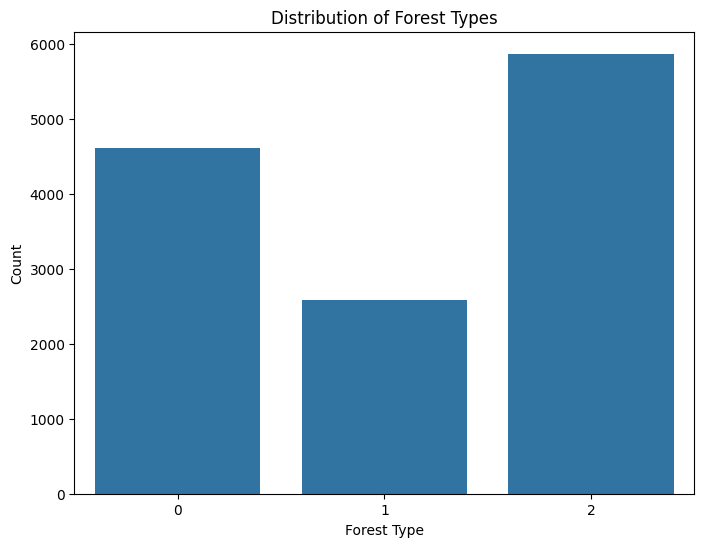

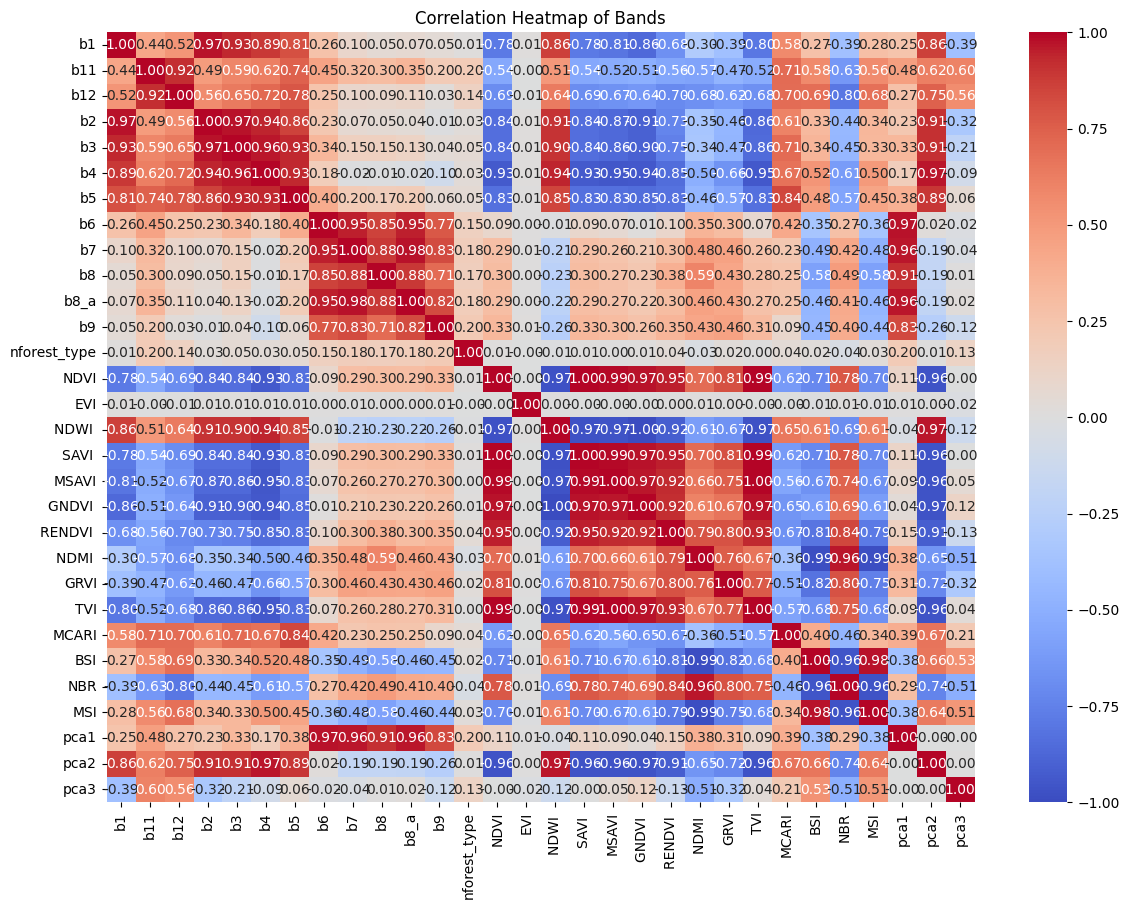

(                 id            b1           b11           b12            b2  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean    8546.088179    352.787482   1785.723742    894.546541    400.200414   
 std     4918.719492    303.240789    336.070954    268.330211    311.052850   
 min        0.000000      0.000000    167.000000     65.000000      1.000000   
 25%     4280.000000    181.000000   1530.000000    697.000000    220.000000   
 50%     8540.000000    244.000000   1774.000000    853.000000    285.000000   
 75%    12798.000000    402.000000   2012.000000   1046.000000    453.000000   
 max    17051.000000   2616.000000   4110.000000   4994.000000   2480.000000   
 
                  b3            b4            b5            b6            b7  \
 count  13053.000000  13053.000000  13053.000000  13053.000000  13053.000000   
 mean     578.862560    442.523481    896.518885   2056.567226   2512.113001   
 std      290.515207    293.689997    

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary_stats = train_df_new_num.describe()

# Distribution of forest types
forest_type_distribution = train_df_new_num['nforest_type'].value_counts()

# Correlation analysis
correlation_matrix = train_df_new_num.drop(columns=['id']).corr()

# Plotting the distribution of forest types
plt.figure(figsize=(8, 6))
sns.barplot(x=forest_type_distribution.index, y=forest_type_distribution.values)
plt.title('Distribution of Forest Types')
plt.xlabel('Forest Type')
plt.ylabel('Count')
plt.show()

# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Bands')
plt.show()

summary_stats, forest_type_distribution

--------

# Step 1: Initial Training and Hyperparameter Tuning with Optuna

In [71]:
# !pip install catboost

In [72]:
# !pip install optuna-integration

In [73]:
# Assign X, y for splittinf train and val
X = train_df_new_num.drop(['id', 'nforest_type'], axis=1)
y = train_df_new_num['nforest_type']

**OptunaSearchCV:** hyperparameter tuning for each classifier (results compiled into df)

In [74]:
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from imblearn.over_sampling import SMOTE

In [43]:
X_train.shape[0]

14964

In [46]:
X_train.shape[0]/8

1870.5

In [44]:
X_val.shape[0]

1958

In [ ]:
# Set parameters
VAL_SPLIT = 0.15
CV_NUM = 8
SCALE = MinMaxScaler()
seed = 42

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, stratify=y, random_state=seed)

# Balance the classes using SMOTE
smote = SMOTE(random_state=seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the data
X_train = SCALE.fit_transform(X_train_balanced)
X_val = SCALE.transform(X_val)

# Define K-Fold cross-validation
kfold = StratifiedKFold(n_splits=CV_NUM, shuffle=True, random_state=seed)


# Define classifiers and their parameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'solver': optuna.distributions.CategoricalDistribution(['lbfgs', 'saga'])
    }),
    "KNeighborsClassifier": (KNeighborsClassifier(), {
        'n_neighbors': optuna.distributions.IntDistribution(1, 50),
        'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance'])
    }),
    "DecisionTreeClassifier": (DecisionTreeClassifier(random_state=seed), {
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16)
    }),
    "AdaBoostClassifier": (AdaBoostClassifier(DecisionTreeClassifier(random_state=seed), random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True)
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_samples_split': optuna.distributions.IntDistribution(2, 16),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
    }),
    "GradientBoostingClassifier": (GradientBoostingClassifier(random_state=seed), {
        'n_estimators': optuna.distributions.IntDistribution(50, 200),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32)
    }),
    "SVC": (SVC(), {
        'C': optuna.distributions.FloatDistribution(1e-4, 1e2, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid'])
    }),
    "MLPClassifier": (MLPClassifier(random_state=seed), {
        'hidden_layer_sizes': optuna.distributions.CategoricalDistribution([(50,), (100,), (50, 50), (100, 100)]),
        'activation': optuna.distributions.CategoricalDistribution(['relu', 'tanh', 'logistic','identity']),
        'alpha': optuna.distributions.FloatDistribution(1e-4, 1e-2, log=True),
        'learning_rate_init': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_iter': optuna.distributions.IntDistribution(200, 1000)
    }),
    "XGBClassifier": (XGBClassifier(random_state=seed, tree_method='gpu_hist'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'max_depth': optuna.distributions.IntDistribution(1, 32),
        'min_child_weight': optuna.distributions.IntDistribution(1, 10)
    }),
    "LGBMClassifier": (LGBMClassifier(random_state=seed, device='gpu'), {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'num_leaves': optuna.distributions.IntDistribution(2, 256),
        'boosting_type': optuna.distributions.CategoricalDistribution(['gbdt', 'dart'])
    }),
    "CatBoostClassifier": (CatBoostClassifier(random_state=seed, verbose=0, task_type='GPU'), {
        'iterations': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),
        'depth': optuna.distributions.IntDistribution(1, 16)
    })
}

# Perform hyperparameter tuning using Optuna
optuna_results = []

for name, (classifier, param_grid) in classifiers.items():
    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    optuna_search.fit(X_train, y_train_balanced)
    best_estimator = optuna_search.best_estimator_
    best_params = optuna_search.best_params_
    best_score = optuna_search.best_score_
    print(f'[model: {name}]')
    print("Best Parameters: ", best_params)
    print("Best Estimator: ", best_estimator)
    print("Best Score: ", best_score)
    print('---------------------')
    optuna_results.append((name, best_score, best_params, best_estimator))

# Compile the results
optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
print(optuna_results_df)

optuna_results_df.to_csv(f'{results_path}/optuna_results_df_feat01.csv', index=False)

/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution

[model: LogisticRegression]
Best Parameters:  {'C': 0.30231331275929324, 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=0.30231331275929324, max_iter=1000)
Best Score:  0.6213311473721256
---------------------


[I 2024-06-05 19:06:44,631] Trial 4 finished with value: 0.7476414723192648 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 4 with value: 0.7476414723192648.
[I 2024-06-05 19:06:44,724] Trial 1 finished with value: 0.7309261651545194 and parameters: {'n_neighbors': 9, 'weights': 'distance'}. Best is trial 4 with value: 0.7476414723192648.
[I 2024-06-05 19:06:44,808] Trial 5 finished with value: 0.6785029384583251 and parameters: {'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 4 with value: 0.7476414723192648.
[I 2024-06-05 19:06:44,828] Trial 0 finished with value: 0.7183562802036034 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 4 with value: 0.7476414723192648.
[I 2024-06-05 19:06:44,904] Trial 8 finished with value: 0.7210304704108406 and parameters: {'n_neighbors': 16, 'weights': 'distance'}. Best is trial 4 with value: 0.7476414723192648.
[I 2024-06-05 19:06:44,946] Trial 6 finished with value: 0.7186907909231108 and par

[model: KNeighborsClassifier]
Best Parameters:  {'n_neighbors': 2, 'weights': 'distance'}
Best Estimator:  KNeighborsClassifier(n_neighbors=2, weights='distance')
Best Score:  0.7476414723192648
---------------------


[I 2024-06-05 19:06:45,763] Trial 0 finished with value: 0.4799058234121023 and parameters: {'max_depth': 1, 'min_samples_split': 11}. Best is trial 0 with value: 0.4799058234121023.
[I 2024-06-05 19:06:46,102] Trial 7 finished with value: 0.5358744417072243 and parameters: {'max_depth': 2, 'min_samples_split': 3}. Best is trial 7 with value: 0.5358744417072243.
[I 2024-06-05 19:06:47,633] Trial 5 finished with value: 0.615781016185841 and parameters: {'max_depth': 7, 'min_samples_split': 9}. Best is trial 5 with value: 0.615781016185841.
[I 2024-06-05 19:06:49,005] Trial 8 finished with value: 0.6478087813266267 and parameters: {'max_depth': 13, 'min_samples_split': 12}. Best is trial 8 with value: 0.6478087813266267.
[I 2024-06-05 19:06:49,181] Trial 2 finished with value: 0.6468734173955588 and parameters: {'max_depth': 14, 'min_samples_split': 10}. Best is trial 8 with value: 0.6478087813266267.
[I 2024-06-05 19:06:49,554] Trial 9 finished with value: 0.6575051215583271 and paramet

[model: DecisionTreeClassifier]
Best Parameters:  {'max_depth': 20, 'min_samples_split': 4}
Best Estimator:  DecisionTreeClassifier(max_depth=20, min_samples_split=4, random_state=42)
Best Score:  0.6575051215583271
---------------------


/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ai4054/.conda/envs/pim-env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[model: AdaBoostClassifier]
Best Parameters:  {'n_estimators': 140, 'learning_rate': 0.056708429905316105}
Best Estimator:  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                   learning_rate=0.056708429905316105, n_estimators=140,
                   random_state=42)
Best Score:  0.6550975599637199
---------------------


[I 2024-06-05 19:07:08,790] Trial 9 finished with value: 0.5103292031828053 and parameters: {'n_estimators': 185, 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.5103292031828053.
[I 2024-06-05 19:07:10,359] Trial 7 finished with value: 0.5362071641731259 and parameters: {'n_estimators': 126, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.5362071641731259.
[I 2024-06-05 19:07:32,817] Trial 4 finished with value: 0.7270479080294017 and parameters: {'n_estimators': 81, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.7270479080294017.
[I 2024-06-05 19:07:35,077] Trial 2 finished with value: 0.7423600441197928 and parameters: {'n_estimators': 79, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.7423600441197928.
[I 2024-06-05 19:07:35,131] Trial 1 finished with value: 0.7484457930260972 and parameters: {'

[model: RandomForestClassifier]
Best Parameters:  {'n_estimators': 105, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1}
Best Estimator:  RandomForestClassifier(max_depth=20, min_samples_split=7, n_estimators=105,
                       random_state=42)
Best Score:  0.7542631965963096
---------------------


[I 2024-06-05 19:10:39,924] Trial 9 finished with value: 0.5237706114110608 and parameters: {'n_estimators': 155, 'learning_rate': 0.00207978475326079, 'max_depth': 1}. Best is trial 9 with value: 0.5237706114110608.
[I 2024-06-05 19:12:31,584] Trial 1 finished with value: 0.6203288312260553 and parameters: {'n_estimators': 138, 'learning_rate': 0.04083230436732145, 'max_depth': 2}. Best is trial 1 with value: 0.6203288312260553.
[I 2024-06-05 19:14:29,967] Trial 2 finished with value: 0.6190585273946146 and parameters: {'n_estimators': 135, 'learning_rate': 0.015635771837303143, 'max_depth': 3}. Best is trial 1 with value: 0.6203288312260553.
[I 2024-06-05 19:22:30,848] Trial 8 finished with value: 0.7293869437458333 and parameters: {'n_estimators': 182, 'learning_rate': 0.06601180806334964, 'max_depth': 5}. Best is trial 8 with value: 0.7293869437458333.
[I 2024-06-05 19:31:44,635] Trial 5 finished with value: 0.7444333453503975 and parameters: {'n_estimators': 68, 'learning_rate': 0

In [ ]:
optuna_results

### *** if error occurred during hyperparams tuning

In [18]:
###for error debugging
optuna_results_df_err = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters", "Best Estimator"])
optuna_results_df_err.to_csv(f'{results_path}/optuna_results_df_feat01-not-finished.csv', index=False)

In [19]:
optuna_results_df_err['Model']

0            LogisticRegression
1          KNeighborsClassifier
2        DecisionTreeClassifier
3            AdaBoostClassifier
4        RandomForestClassifier
5    GradientBoostingClassifier
6                           SVC
7                 MLPClassifier
8                 XGBClassifier
Name: Model, dtype: object

In [20]:
# Perform hyperparameter tuning using Optuna
optuna_results = []

# Skip models that have already been trained
trained_models = optuna_results_df_err['Model'].tolist()

for name, (classifier, param_grid) in classifiers.items():
    if name in trained_models:
        print(f'Skipping already trained model: {name}')
        continue

    optuna_search = OptunaSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        random_state=seed
    )
    try:
        optuna_search.fit(X_train, y_train_balanced)
        best_estimator = optuna_search.best_estimator_
        best_params = optuna_search.best_params_
        best_score = optuna_search.best_score_
        print(f'[model: {name}]')
        print("Best Parameters: ", best_params)
        print("Best Estimator: ", best_estimator)
        print("Best Score: ", best_score)
        print('---------------------')
        optuna_results.append((name, best_score, best_params))
    except Exception as e:
        print(f'Error training model {name}: {e}')

# Compile the results
new_optuna_results_df = pd.DataFrame(optuna_results, columns=["Model", "Best Score", "Best Parameters"])

# Combine with previous results
combined_optuna_results_df = pd.concat([optuna_results_df, new_optuna_results_df], ignore_index=True)
print(combined_optuna_results_df)

# Save the combined results
combined_optuna_results_df.to_csv(f'{results_path}/combined_optuna_results_df_feat01.csv', index=False)
print(f"Combined results saved to: {results_path}/combined_optuna_results_df_feat01.csv")

<ipython-input-20-cebc5fe5e400>:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-06-05 09:07:08,020] A new study created in memory with name: no-name-344aaf52-d57c-447e-8ce0-ebbc2191f1c2


Skipping already trained model: LogisticRegression
Skipping already trained model: KNeighborsClassifier
Skipping already trained model: DecisionTreeClassifier
Skipping already trained model: AdaBoostClassifier
Skipping already trained model: RandomForestClassifier
Skipping already trained model: GradientBoostingClassifier
Skipping already trained model: SVC
Skipping already trained model: MLPClassifier
Skipping already trained model: XGBClassifier


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:08,974] Trial 5 failed with parameters: {'n_estimators': 79, 'learning_rate': 0.19188234555422495, 'num_leaves': 23, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,978] Trial 5 failed with value nan.
[W 2024-06-05 09:07:08,988] Trial 3 failed with parameters: {'n_estimators': 184, 'learning_rate': 0.13362042989298442, 'num_leaves': 93, 'boosting_type': 'gbdt'} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:08,992] Trial 3 failed with value nan.
[W 2024-06-05 09:07:08,994] Trial 2 failed with parameters: {'n_es

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 14976, number of used features: 29
Error training model LGBMClassifier: No OpenCL device found


/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,398] Trial 1 failed with parameters: {'iterations': 59, 'learning_rate': 0.404665400351513, 'depth': 9} because of the following error: The value nan is not acceptable.
[W 2024-06-05 09:07:14,406] Trial 1 failed with value nan.
/usr/local/lib/python3.10/dist-packages/optuna_integration/sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-06-05 09:07:14,614]

[model: CatBoostClassifier]
Best Parameters:  {'iterations': 150, 'learning_rate': 0.0151103585762203, 'depth': 13}
Best Estimator:  <catboost.core.CatBoostClassifier object at 0x7c54703bffa0>
Best Score:  0.6694043803418803
---------------------
                        Model  Best Score  \
0          LogisticRegression    0.647903   
1        KNeighborsClassifier    0.732505   
2      DecisionTreeClassifier    0.653846   
3          AdaBoostClassifier    0.655115   
4      RandomForestClassifier    0.765425   
5  GradientBoostingClassifier    0.781317   
6                         SVC    0.685029   
7               MLPClassifier    0.691306   
8               XGBClassifier    0.778646   
9          CatBoostClassifier    0.669404   

                                     Best Parameters  
0        {'C': 8.490782592210358, 'solver': 'lbfgs'}  
1          {'n_neighbors': 9, 'weights': 'distance'}  
2          {'max_depth': 31, 'min_samples_split': 2}  
3  {'n_estimators': 180, 'learning_ra

In [21]:
combined_optuna_results_df

,Model,Best Score,Best Parameters
0,LogisticRegression,0.647903,"{'C': 8.490782592210358, 'solver': 'lbfgs'}"
1,KNeighborsClassifier,0.732505,"{'n_neighbors': 9, 'weights': 'distance'}"
2,DecisionTreeClassifier,0.653846,"{'max_depth': 31, 'min_samples_split': 2}"
3,AdaBoostClassifier,0.655115,"{'n_estimators': 180, 'learning_rate': 0.02880..."
4,RandomForestClassifier,0.765425,"{'n_estimators': 130, 'max_depth': 21, 'min_sa..."
5,GradientBoostingClassifier,0.781317,"{'n_estimators': 154, 'learning_rate': 0.11829..."
6,SVC,0.685029,"{'C': 4.61538732142158, 'kernel': 'rbf'}"
7,MLPClassifier,0.691306,"{'hidden_layer_sizes': (100, 100), 'activation..."
8,XGBClassifier,0.778646,"{'n_estimators': 106, 'learning_rate': 0.09181..."
9,CatBoostClassifier,0.669404,"{'iterations': 150, 'learning_rate': 0.0151103..."


In [22]:
optuna_results_df = combined_optuna_results_df.copy()

---------------------------

------------------------------
# Step 2: Select Top Models
## (Include MLPClassifier in the top models)

In [ ]:
# Sort the results by best score
sorted_results_df = optuna_results_df.sort_values(by='Best Score', ascending=False)
print(sorted_results_df)

# Select top 5 models
top_5_models = sorted_results_df.head(5)

# Include CatBoostClassifier in the top models
mlp_result = optuna_results_df[optuna_results_df['Model'] == 'CatBoostClassifier']
top_6_models = pd.concat([top_5_models, mlp_result])

In [ ]:
top_6_models

# Step 3: Predictions

## Retrain each top model(full training data)

In [ ]:
# Ensure all column names are strings before concatenating
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_train_balanced_df.columns = X_train_balanced_df.columns.astype(str)
X_val_df = pd.DataFrame(X_val)
X_val_df.columns = X_val_df.columns.astype(str)

# Retrain each top model on the entire training dataset (including the validation set)
X_combined = SCALE.fit_transform(pd.concat([X_train_balanced_df, X_val_df], axis=0))
y_combined = pd.concat([pd.Series(y_train_balanced), pd.Series(y_val)], axis=0)

retrained_models = []
for index, row in top_6_models.iterrows():
    model_name = row['Model']
    best_estimator = row['Best Estimator']
    best_estimator.fit(X_combined, y_combined)
    retrained_models.append((model_name, best_estimator))

# Evaluate fine-tuned models on the validation set
for model_name, model in retrained_models:
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy for {model_name}: {accuracy}')


## Voting Classifier

In [ ]:
# Custom Voting Classifier Implementation
test_ids = test_df_new['id']
test_features = test_df_new.drop(columns=['id'])
test_features = SCALE.transform(test_features)

# Predict with each of the top models
def predict_with_models(models, test_features):
    predictions = []
    for model_name, model in models:
        predictions.append(model.predict(test_features))
    return np.array(predictions).T

# Weighted voting function
def weighted_voting(predictions, weights):
    final_predictions_encoded = []
    for instance_predictions in predictions:
        weighted_votes = np.zeros(3)  # Assuming there are 3 classes
        for i, vote in enumerate(instance_predictions):
            weighted_votes[vote] += weights[i]
        final_predictions_encoded.append(np.argmax(weighted_votes))
    return final_predictions_encoded

# Perform predictions and voting for top 3, top 5, and the best model
top_3_models = retrained_models[:3]
top_5_models = retrained_models[:5]
best_model = retrained_models[0]

# Calculate weights for models
weights_top_3 = [3, 2, 1]  # Example weights
weights_top_5 = [5, 4, 3, 2, 1]  # Example weights

# Predict and vote
predictions_top_3 = predict_with_models(top_3_models, test_features)
predictions_top_5 = predict_with_models(top_5_models, test_features)
predictions_best = best_model[1].predict(test_features)  # Best model directly

# Weighted voting
final_predictions_top_3 = weighted_voting(predictions_top_3, weights_top_3)
final_predictions_top_5 = weighted_voting(predictions_top_5, weights_top_5)

## Prepare submissions

In [ ]:
# Map the encoded predictions back to the original labels
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
final_predictions_top_3 = [inverse_label_mapping[pred] for pred in final_predictions_top_3]
final_predictions_top_5 = [inverse_label_mapping[pred] for pred in final_predictions_top_5]
final_predictions_best = [inverse_label_mapping[pred] for pred in predictions_best]

# Prepare submission DataFrames
submission_top_3 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_3
})
submission_top_5 = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_top_5
})
submission_best = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions_best
})

# Save submission files
submission_top_3_file_path = '/content/pim_optuna_top_3_submission.csv'
submission_top_5_file_path = '/content/pim_optuna_top_5_submission.csv'
submission_best_file_path = '/content/pim_optuna_best_submission.csv'

submission_top_3.to_csv(submission_top_3_file_path, index=False)
submission_top_5.to_csv(submission_top_5_file_path, index=False)
submission_best.to_csv(submission_best_file_path, index=False)

print(f"Submission files saved at:\n{submission_top_3_file_path}\n{submission_top_5_file_path}\n{submission_best_file_path}")

--------------------------

------------------

In [ ]:
# # Fine-tune each top model
# fine_tuned_models = {}

# def fine_tune_model(model_name, X_train, y_train, kfold):
#     def objective(trial):
#         if model_name == "XGBClassifier":
#             param = {
#                 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#                 'tree_method': 'gpu_hist'  # Use GPU
#             }
#             model = XGBClassifier(**param, random_state=seed)

#         elif model_name == "LGBMClassifier":
#             param = {
#                 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#                 'num_leaves': trial.suggest_int('num_leaves', 31, 127),
#                 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#                 'device': 'gpu'  # Use GPU
#             }
#             model = LGBMClassifier(**param, random_state=seed)

#         elif model_name == "CatBoostClassifier":
#             param = {
#                 'iterations': trial.suggest_int('iterations', 100, 300),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#                 'depth': trial.suggest_int('depth', 4, 10),
#                 'task_type': 'GPU'  # Use GPU
#             }
#             model = CatBoostClassifier(**param, random_state=seed, verbose=0)

#         elif model_name == "RandomForestClassifier":
#             param = {
#                 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#                 'max_depth': trial.suggest_int('max_depth', 10, 50),
#                 'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
#             }
#             model = RandomForestClassifier(**param, random_state=seed)

#         elif model_name == "GradientBoostingClassifier":
#             param = {
#                 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10)
#             }
#             model = GradientBoostingClassifier(**param, random_state=seed)

#         elif model_name == "MLPClassifier":
#             param = {
#                 'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
#                 'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
#                 'alpha': trial.suggest_float('alpha', 1e-4, 1e-2, log=True),
#                 'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, log=True),
#                 'max_iter': trial.suggest_int('max_iter', 200, 1000)
#             }
#             model = MLPClassifier(**param, random_state=seed)

#         else:
#             raise ValueError("Model not supported for fine-tuning.")

#         scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
#         return scores.mean()

#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=50, n_jobs=-1)

#     best_params = study.best_params
#     best_score = study.best_value
#     best_model = globals()[model_name](**best_params)
#     best_model.fit(X_train, y_train)

#     return best_model, best_params, best_score


In [ ]:
# Fine-tune each top model
for model_name in top_6_models['Model']:
    best_model, best_params, best_score = fine_tune_model(model_name, X_train, y_train_balanced, kfold)
    fine_tuned_models[model_name] = (best_model, best_params, best_score)
    print(f'Fine-tuned {model_name}:')
    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')
    print('---------------------')

# Evaluate fine-tuned models on the validation set
for model_name, (best_model, best_params, best_score) in fine_tuned_models.items():
    y_val_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy for {model_name}: {accuracy}')

# Select the final model based on validation performance and retrain on the entire training dataset
final_model_name = max(fine_tuned_models, key=lambda k: accuracy_score(y_val, fine_tuned_models[k][0].predict(X_val)))
final_model = fine_tuned_models[final_model_name][0]

# Retrain on the entire training dataset (including the validation set)
X_combined = SCALE.fit_transform(pd.concat([pd.DataFrame(X_train_balanced), pd.DataFrame(X_val)]))
y_combined = pd.concat([pd.Series(y_train_balanced), pd.Series(y_val)])
final_model.fit(X_combined, y_combined)

print(f'Final model selected: {final_model_name}')

--------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Define the label mapping
label_mapping = {'DDF': 0, 'DEF': 1, 'MDF': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

test_ids = test_df_new['id']

# Ensure test_df_new is preprocessed and scaled appropriately
test_features = test_df_new.drop(columns=['id'])
test_features = SCALE.transform(test_features)

# Select top 6 models based on validation accuracy
top_6_models = sorted(fine_tuned_models.items(), key=lambda item: accuracy_score(y_val, item[1][0].predict(X_val)), reverse=True)[:6]

# Print the selected models
print("Selected models for ensemble:")
for model_name, (model, params, score) in top_6_models:
    print(f'{model_name}: Validation Accuracy = {accuracy_score(y_val, model.predict(X_val))}')

In [ ]:
# Retrain each top model on the entire training dataset (including the validation set)
X_combined = SCALE.fit_transform(pd.concat([pd.DataFrame(X_train_balanced), pd.DataFrame(X_val)]))
y_combined = pd.concat([pd.Series(y_train_balanced), pd.Series(y_val)])

retrained_models = []
for model_name, (model, params, score) in top_6_models:
    retrained_model = model.__class__(**params)
    retrained_model.fit(X_combined, y_combined)
    retrained_models.append((model_name, retrained_model))

In [ ]:
# Predict with each of the top 6 models
predictions = []
for model_name, model in retrained_models:
    predictions.append(model.predict(test_features))

# Transpose the list of predictions to get predictions for each test instance across models
predictions = np.array(predictions).T

# Custom voting: select the result if agreed upon by at least 4 models
final_predictions_encoded = []
for instance_predictions in predictions:
    counts = np.bincount(instance_predictions)
    if np.max(counts) >= 4:
        final_predictions_encoded.append(np.argmax(counts))
    else:
        final_predictions_encoded.append(np.argmax(counts))  # Default to the most common prediction if no consensus

# Map the encoded predictions back to the original labels
final_predictions = [inverse_label_mapping[pred] for pred in final_predictions_encoded]

# Map the individual model predictions back to the original labels
predictions_decoded = np.vectorize(inverse_label_mapping.get)(predictions)

# Print the predictions
print("Predictions for test_df_new:")
print(final_predictions)

In [ ]:
# Prepare the submission DataFrame with all predictions
voting_submission_df = pd.DataFrame({
    'id': test_ids,
    'nforest_type': final_predictions
})

# Add individual model predictions to the submission DataFrame
for i, (model_name, _) in enumerate(retrained_models):
    voting_submission_df[f'prediction_{i+1}'] = predictions_decoded[:, i]

# Save the submission file
voting_submission_file_path = '/content/pim_optuna_feat01_submission.csv'
voting_submission_df.to_csv(voting_submission_file_path, index=False)

print(f"Submission file saved at: {voting_submission_file_path}")

------------------------------

-----

# Check similarity between two results

Training results should have classes Label Mapping (Original to Encoded): {'DDF': 0, 'DEF': 1, 'MDF': 2}
- DDF(0): 1488
- DEF(1): 1000
- MDF(2): 1512
(Total: 4000)

------------------
------------------
### Results record
**submission_majority_voting_1.csv**
- score acc 0.65615
- Number of DDF: 1400, DEF:831, MDF:1769

.........................

**submission_majority_voting_2.csv**
```
Raw Data
Split 0.15, cv_num = 8 for girdsearchCV  
เปิดtrain+SMOTE ให้เห็นหมดตอน Majority vote
```
- score acc 0.66480
- Number of DDF: 1402, DEF:848, MDF:1750

.........................

**submission_majority_voting_prepdat01.csv**
```
prepdata select features: ['b2', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'NDVI', 'Moisture_Index', 'natural_color', 'false_color', 'vegetation_analysis', 'swir']
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

```
- score: 0.62767
- Number of DDF: 1384, DEF:827, MDF:1789

.........................

**submission_majority_voting_prepdat02.csv**
```
prepdata 18 features
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote

Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.66429
- Number of DDF: 1434, DEF:856, MDF:1710

.........................


**submission_3voting_prepfeats.csv**
```
data with 29 features (jane's features no drop)
Split 0.15, cv_num = 8 for girdsearchCV  
เปิด train + SMOTE ให้เห็นหมดตอน Majority vote
```
- score: 0.67293
- Number of DDF: 1420, DEF:835, MDF:1745

.........................


------------------
------------------